In [186]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from scipy import stats
from scipy import optimize as opt

# I. Distributions and probability 

## 1.1 El classico
The probability is described by the binomial distribution

In [2]:
n, k = 144, int(144/2)
p = special.comb(n,k)*.5**k*.5**(n-k)

### 1.2 Golf 

Probably cumulative distribution needed 

In [3]:
p_hit = 0.054
n_arr = np.arange(1,1000)
Acc_prob = n_arr*p_hit*(1-p_hit)**(n_arr-1)
np.argmax(Acc_prob>.9)

0

# II. Error propagation 

## 2.1 Hubble constant 

In [4]:
h_mean = np.array([73.5, 74.0, 73.3, 75.0, 67.6, 70.4, 67.66])
h_err = np.array([1.4, 1.4, 1.8, 2.0, .7, 1.4, .42])

- weighted average

In [5]:
def weighted_avg(mean, sigma): return np.sum(mean/sigma**2)/np.sum(1/sigma**2)
h_wavg = weighted_avg(h_mean, h_err)
print(h_wavg)

68.78925107187163


The values do not agree with each other

- values from same method 

In [6]:
h_wavg1 = weighted_avg(h_mean[:4], h_err[:4])
h_wavg2 = weighted_avg(h_mean[4:], h_err[4:])
print(h_wavg1, h_wavg2)

73.85994654752882 67.8151724137931


The values do agree with each other 

## 2.2 Coulomb 

- Find $q_0$ 

In [7]:
k_e, Q = 8.99e9, 1e-9
F, dF = .87, .08
d, dd = .0045, .0003

Gaussian error propagation results in: 

In [8]:
dq0 = d/(k_e*Q)*np.sqrt((2*F*dd)**2+(d*dF)**2)
print(2*F*dd, d*dF)

0.000522 0.00035999999999999997


- The greater error results from the uncertainty in d 

- where is the charge most porecisely\
Not sure about this point 

In [9]:
dF2, dd2 = .01, .0001
dq02 = d/(k_e*Q)*np.sqrt((2*F*dd2)**2+(d*dF2)**2)
z1 = (-(2*F*dd2)**2+np.sqrt((2*F*dd2)**4+4*(dF2*dq02*Q*k_e)**2))/(2*dF2)**2
z2 =(-(2*F*dd2)**2-np.sqrt((2*F*dd2)**4+4*(dF2*dq02*Q*k_e)**2))/(2*dF2)**2
print(z1, z2)

1.0124999999999999e-05 -0.000161505


In [10]:
d_prec = np.sqrt(z1)
d_prec

0.003181980515339464

## 2.3 Neanderthal DNA 

In [57]:
DNA = np.loadtxt("DNA.txt")
mean = np.mean(DNA)
RMS = np.sum((DNA-mean)**2)/len(DNA)
print(RMS)

1.1262560116535557e-05


Three peaks each gaussian distributed 

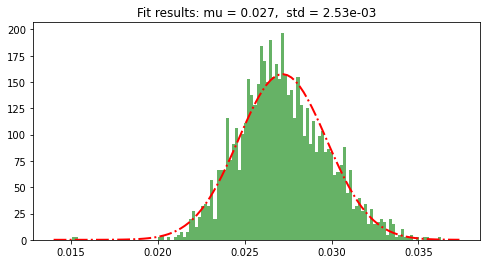

In [60]:
DNA_mask = DNA >.015
DNA2 = DNA[DNA_mask]
# Fit a normal distribution to the data:
mu, std = stats.norm.fit(DNA2)
plt.figure(figsize=(8,4))
plt.hist(DNA2, bins=120, density=True, alpha=0.6, color='g') # Plot the histogram.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, '-.r', linewidth=2)
title = "Fit results: mu = %.3f,  std = %.2e" % (mu, std)
plt.title(title)
plt.show()

Comment on the fits 

# III. Monte Carlo

## 3.1 

Normalize:\
$\int_{1}^{10}dx\;C\cdot(c_1+x^{c_2})=1\\
\leftrightarrow C\cdot \big[ 50 - 5 + 1/3\cdot(10^3-1)\big]=1\\
\leftrightarrow C = 1/378$

In [214]:
C = 1/378
c1,c2 = 5,2
class my_pdf(stats.rv_continuous):
    def _pdf(self,x,c1,c2):
        return C*(c1+x**c2)  # Normalized over its range, in this case [1,10]

my_cv = my_pdf(a=1, b=10, name='my_pdf')
x_arr = my_cv.rvs(size = 5000, c1 =c1, c2 =c2)

### Compute mean and RMS
- analytically
$\\ \overline{x} = C\cdot \int_1^{10}dx\,x\cdot f(x) = C \cdot \big(5/2\cdot 99 + 1/4\cdot 9999\big)\\
\overline{x^2} = C\cdot \int_1^{10}dx\,x^2\cdot f(x) = C\cdot \big(5/3\cdot 999+1/5\cdot 99999\big)\\
RMS = \sqrt{\overline{x^2}-\overline{x}^2}$
- MC

In [215]:
mean_f = C * (5/2*99+1/4*9999)
sec_mom_f = C*(5/3*999+1/5*99999)
RMS_f = np.sqrt(sec_mom_f-mean_f**2)
mean_f, RMS_f

(7.267857142857142, 2.1195608661480168)

In [216]:
mean_MC = np.mean(x_arr) 
RMS_MC = np.sqrt(np.sum((x_arr-mean_MC)**2)/len(x_arr))
mean_MC, RMS_MC

(7.270208894812458, 2.08706775771805)

<AxesSubplot:>

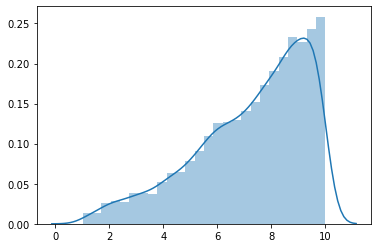

In [217]:
sns.distplot(x_arr)

In [218]:
y_arr =  x_arr*np.exp(-x_arr)
correlation = np.corrcoef(x_arr,y_arr)
correlation[0,1]

-0.772416076520305

doesn't work for some reason
should return fitted params and loc and scale

In [220]:
c1fit, c2fit, loc, scale = my_cv.fit(x_arr, 5 ,2)
c1fit, c2fit

(0.021747264141457313, 6.513092294524204)

# IV. Statistical Tests 

## 4.1 

- Selecting P-cells (l<9) and counting error type I and type II rate 

In [228]:
cells = np.loadtxt("data_cells.txt")
mask_P = cells[:,1]<9
P_cells = cells[mask_P]
P_cells_I = np.sum(P_cells[:,0])/len(P_cells)
P_cells_II = (len(P_cells)-np.sum(P_cells[:,0]))/len(P_cells)
P_cells_I, P_cells_II

(0.09707686755683868, 0.9029231324431614)

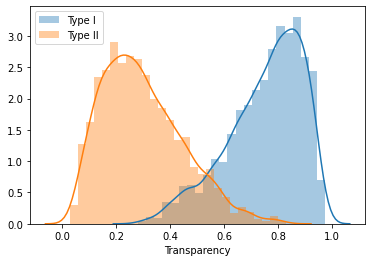

In [244]:
sns.distplot(cells[cells[:,0]==1][:,2],label =  "Type I")
sns.distplot(cells[cells[:,0]==0][:,2], label = "Type II")
plt.legend()
plt.xlabel('Transparency')
plt.show()

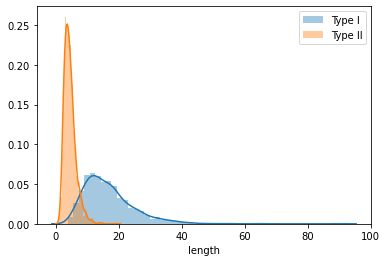

In [245]:
sns.distplot(cells[cells[:,0]==1][:,1],label =  "Type I")
sns.distplot(cells[cells[:,0]==0][:,1], label = "Type II")
plt.legend()
plt.xlabel('length')
plt.show()

In [249]:
corr_transp = np.corrcoef(cells[:,2],cells[:,0])
corr_len = np.corrcoef(cells[:,1],cells[:,0])
corr_transp[0,1], corr_len[0,1]

(0.8415776123141836, 0.7402420921027675)